# Modelo RFM y Segmentación de Clientes — Nike Colombia

El modelo **RFM (Recency, Frequency, Monetary Value)** es una metodología clásica y ampliamente validada en *marketing analytics* para segmentar clientes con base en su comportamiento transaccional.  
Se fundamenta en tres dimensiones clave:

- **Recency (R):** tiempo transcurrido desde la última compra.  
  - A menor recency, mayor probabilidad de recompra.
- **Frequency (F):** número de compras realizadas en el período de observación.  
  - Clientes más frecuentes tienden a ser más leales.
- **Monetary Value (M):** monto total gastado.  
  - Indica el valor económico de cada cliente para la marca.

El análisis RFM permite identificar grupos de clientes con comportamientos similares (por ejemplo, *Champions*, *Leales recientes*, *En riesgo*, *Dormidos*, etc.) y diseñar estrategias diferenciadas de marketing, retención o activación.

En el contexto de **Nike Colombia**, donde la información disponible proviene de las **transacciones en línea**, el modelo RFM es especialmente adecuado, ya que resume la interacción del cliente con la marca sin requerir información demográfica o psicográfica adicional.

In [1]:
# ======================================
# 1. Importación de librerías
# ======================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# ======================================
# 2. Lectura y consolidación de archivos
# ======================================

# Nombre del archivo principal de datos
fname = "BASE ACTUALIZADA A OCTUBRE 2025.xlsx"

# Ruta local (si el archivo está en la carpeta 'data/' del repo clonado)
local_path = os.path.join("data", fname)

# URL al archivo en GitHub (repositorio público)
raw_url = (
    "https://raw.githubusercontent.com/"
    "daviid24/Proyecto-Maestria-MIIA/main/data/"
    "BASE%20ACTUALIZADA%20A%20OCTUBRE%202025.xlsx"
)

# Si el archivo existe localmente, se lee desde el disco
# En caso contrario, se descarga directamente desde GitHub
if os.path.exists(local_path):
    orders = pd.read_excel(local_path)
else:
    orders = pd.read_excel(raw_url)

# Vista previa de la base cargada
orders.head()

,FechaSinHora,Order,Client Document,UF,City,RealDiscount,Discounts Names,Shipping Status,Model,BU,Género,Categoría,Familia/Silueta,Unidades,Valor Pagado
0,2024-02-06,1408880501419-01,1010121222,Antioquia,Medellín,Base inline,Flete Gratis,No Shipping Payment,BV2772-010,Apparel Division,HOMBRE (MENS),NIKE SPORTSWEAR,KNEE LENGTH SHORT,1,155420
1,2024-02-06,1408840501369-01,80122644,"Bogotá, D.C.","Bogotá, D.c.",Base inline,Flete Gratis,No Shipping Payment,CN8490-002,Footwear Division,HOMBRE (MENS),NIKE SPORTSWEAR,AM 90,1,575588
2,2024-02-06,1408830501357-01,1047499286,Bolívar,Cartagena De Indias,Base inline,Flete Gratis,No Shipping Payment,CU8890-651,Apparel Division,MUJER (WOMENS),RUNNING,SHORT,1,134412
3,2024-02-06,1408860501387-01,80096408,Cundinamarca,Cajicá,Base inline,NaN,Shipping Payment,CV2545-100,Apparel Division,HOMBRE (MENS),TENNIS,MID THIGH LENGTH SHORT,1,210042
4,2024-02-06,1408810501345-01,91018601,Santander,Barbosa,Base inline,Flete Gratis,No Shipping Payment,DC7695-003,Footwear Division,HOMBRE (MENS),ACTION SPORTS,BLAZER,1,373908


In [2]:
# ======================================
# 3. Limpieza y normalización de nombres
# ======================================
orders.columns = (
    orders.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("/", "_")
    .str.replace("-", "_")
)

# Variables clave
DATE_COL = "FechaSinHora"
CLIENT_ID = "Client_Document"
PAID_COL = "Valor_Pagado"
BU_COL = "BU"

# Conversión de fecha
orders[DATE_COL] = pd.to_datetime(orders[DATE_COL], errors="coerce")

# ======================================
# 4. Limpieza de registros de empleados
# ======================================

# Asegurar normalización de nombres de columnas
orders.columns = orders.columns.str.strip().str.replace(" ", "_")

# Filtrar registros que NO correspondan a empleados
initial_rows = orders.shape[0]

orders = orders[
    ~orders["Discounts_Names"].astype(str).str.lower().str.contains("emplead", na=False)
]

# Reporte de limpieza
removed = initial_rows - orders.shape[0]
print(f"Registros eliminados (empleados): {removed:,}")


# ======================================
# 5. Resumen general de la base
# ======================================
n_clients = orders[CLIENT_ID].nunique()
n_orders = orders.shape[0]
date_min, date_max = orders[DATE_COL].min(), orders[DATE_COL].max()
n_days = (date_max - date_min).days

print(f"Clientes únicos : {n_clients:,.0f}")
print(f"Órdenes totales : {n_orders:,.0f}")
print(f"Ventana temporal: {date_min.date()} → {date_max.date()}  ({n_days} días ≈ {n_days/30:.1f} meses)")

# Vista preliminar de los datos
display(orders.head())

Registros eliminados (empleados): 594
Clientes únicos : 43,663
Órdenes totales : 77,539
Ventana temporal: 2024-02-06 → 2025-10-31  (633 días ≈ 21.1 meses)


,FechaSinHora,Order,Client_Document,UF,City,RealDiscount,Discounts_Names,Shipping_Status,Model,BU,Género,Categoría,Familia_Silueta,Unidades,Valor_Pagado
0,2024-02-06,1408880501419-01,1010121222,Antioquia,Medellín,Base inline,Flete Gratis,No Shipping Payment,BV2772-010,Apparel Division,HOMBRE (MENS),NIKE SPORTSWEAR,KNEE LENGTH SHORT,1,155420
1,2024-02-06,1408840501369-01,80122644,"Bogotá, D.C.","Bogotá, D.c.",Base inline,Flete Gratis,No Shipping Payment,CN8490-002,Footwear Division,HOMBRE (MENS),NIKE SPORTSWEAR,AM 90,1,575588
2,2024-02-06,1408830501357-01,1047499286,Bolívar,Cartagena De Indias,Base inline,Flete Gratis,No Shipping Payment,CU8890-651,Apparel Division,MUJER (WOMENS),RUNNING,SHORT,1,134412
3,2024-02-06,1408860501387-01,80096408,Cundinamarca,Cajicá,Base inline,NaN,Shipping Payment,CV2545-100,Apparel Division,HOMBRE (MENS),TENNIS,MID THIGH LENGTH SHORT,1,210042
4,2024-02-06,1408810501345-01,91018601,Santander,Barbosa,Base inline,Flete Gratis,No Shipping Payment,DC7695-003,Footwear Division,HOMBRE (MENS),ACTION SPORTS,BLAZER,1,373908


In [3]:
# ======================================
# 6. Construcción de variables R, F, M
# ======================================

import numpy as np
import pandas as pd

# Fecha de referencia (último día del histórico)
snap_date = orders[DATE_COL].max()

# ===============================
# 6.1 Tabla base por cliente
# ===============================
# freq: número de órdenes. Si no tienes un ORDER_ID único, usamos la fecha de la orden (nunique)
rfm_base = (
    orders.groupby(CLIENT_ID, as_index=False)
    .agg(
        last_purchase_date=(DATE_COL, "max"),
        frequency=(DATE_COL, "nunique"),         # Ajusta a ORDER_ID si lo tienes
        monetary=(PAID_COL, "sum")
    )
)

# Recency (en días desde la última compra)
rfm_base["recency_days"] = (snap_date - rfm_base["last_purchase_date"]).dt.days

# ===============================
# 6.2 Variables continuas (R, F, M)
# ===============================
rfm_cont = rfm_base[[CLIENT_ID, "recency_days", "frequency", "monetary"]].copy()
rfm_cont.columns = [CLIENT_ID, "R_cont", "F_cont", "M_cont"]

# ===============================
# 6.3 Discretización en 1..5
#     - R_score y M_score por cuantiles (quintiles)
#     - F_score por BINS MANUALES (evitar sesgo/empates de e-commerce)
# ===============================
def score_by_quantiles(series, q=[0, .2, .4, .6, .8, 1.0], higher_is_better=True):
    """
    Devuelve scores 1..5 según cuantiles.
    - higher_is_better=True: valores altos => score alto (M)
    - higher_is_better=False: valores altos => score bajo (R)
    Maneja empates con un fallback por percentiles.
    """
    s = series.fillna(series.median())
    qs = np.unique(np.quantile(s, q))
    if len(qs) < 6:
        ranks = s.rank(method="average", pct=True)
        bins = pd.cut(
            ranks, bins=[0,.2,.4,.6,.8,1.0],
            labels=[1,2,3,4,5], include_lowest=True
        ).astype(int)
    else:
        labels = [1,2,3,4,5]
        if higher_is_better:
            bins = pd.cut(
                s, bins=qs, labels=labels,
                include_lowest=True, duplicates="drop"
            ).astype(int)
        else:
            inv_labels = [5,4,3,2,1]
            bins = pd.cut(
                s, bins=qs, labels=inv_labels,
                include_lowest=True, duplicates="drop"
            ).astype(int)
    return bins

rfm_disc = rfm_base[[CLIENT_ID, "recency_days", "frequency", "monetary"]].copy()

# R y M por cuantiles (quintiles)
rfm_disc["R_score"] = score_by_quantiles(rfm_disc["recency_days"], higher_is_better=False)
rfm_disc["M_score"] = score_by_quantiles(rfm_disc["monetary"],      higher_is_better=True)

# ⚠️ F_score por BINS MANUALES (mejor distribución e interpretabilidad en e-commerce)
#    1 compra = F1, 2 = F2, 3 = F3, 4–5 = F4, 6+ = F5
rfm_disc["F_score"] = pd.cut(
    rfm_disc["frequency"],
    bins=[0, 1, 2, 3, 5, np.inf],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
).astype(int)

# ===============================
# 6.4 Consolidación final RFM
# ===============================
rfm = (
    rfm_disc
    .merge(rfm_cont, on=CLIENT_ID, how="left")
    .assign(
        RFM_code=lambda df: (
            "R" + df["R_score"].astype(str) +
            "F" + df["F_score"].astype(str) +
            "M" + df["M_score"].astype(str)
        )
    )
)

# ===============================
# 6.5 Chequeos rápidos
# ===============================
print("Primeras filas RFM:")
display(rfm.head())

print("\nDistribución de scores (conteo):")
print(
    rfm[["R_score","F_score","M_score"]]
    .apply(pd.Series.value_counts)
    .fillna(0)
    .astype(int)
)

print("\nRecency promedio por R_score (debe decrecer):")
print(rfm.groupby("R_score")["R_cont"].mean().round(1))

print("\nFrecuencia promedio por F_score (debe crecer):")
print(rfm.groupby("F_score")["F_cont"].mean().round(2))


Primeras filas RFM:


,Client_Document,recency_days,frequency,monetary,R_score,M_score,F_score,R_cont,F_cont,M_cont,RFM_code
0,0,470,1,768866,1,4,1,470,1,768866,R1F1M4
1,2323,317,1,176445,3,1,1,317,1,176445,R3F1M1
2,10523,116,1,234429,4,1,1,116,1,234429,R4F1M1
3,41603,343,3,1115876,2,5,3,343,3,1115876,R2F3M5
4,88422,143,1,810882,4,5,1,143,1,810882,R4F1M5



Distribución de scores (conteo):
   R_score  F_score  M_score
1     8719    35216     8733
2     8668     5767     8771
3     8805     1531     8784
4     8734      796     8642
5     8737      353     8733

Recency promedio por R_score (debe decrecer):
R_score
1    514.0
2    355.9
3    277.5
4    141.8
5     40.7
Name: R_cont, dtype: float64

Frecuencia promedio por F_score (debe crecer):
F_score
1    1.00
2    2.00
3    3.00
4    4.28
5    8.08
Name: F_cont, dtype: float64


## Metodología de segmentación

Una vez calculadas las variables R, F y M, se aplican técnicas de **clustering no supervisado** para agrupar clientes con patrones de comportamiento similares.  
En este proyecto se evalúan dos enfoques complementarios:

### K-Means Clustering
El algoritmo **K-Means** busca particionar a los clientes en *k* grupos mutuamente excluyentes, minimizando la distancia dentro de cada cluster (homogeneidad) y maximizando la distancia entre clusters (heterogeneidad).  
Su ventaja principal es la **simplicidad, estabilidad e interpretabilidad**, lo que lo convierte en la base ideal para construir una segmentación accionable y reproducible.

Se evalúa K-Means sobre dos versiones de las variables RFM:
- **Variables continuas:** usando los valores originales (días, número de compras, monto total).  
- **Variables discretizadas:** asignando puntuaciones de 1 a 5 según cuantiles (más interpretable y más robusto a outliers).

### 1. K-Means Clustering (variables continuas)

In [31]:
# ======================================
# K-means — (Variables continuas)
# ======================================
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42  # reproducibilidad

# Selección de features (continuas)
features = ["R_cont", "F_cont", "M_cont"]

# transformaciones:
# - Recency: ya está en días (no transformar)
# - Frequency y Monetary: suelen ser sesgadas; log1p ayuda a estabilizar
rfm_km = rfm.copy()

rfm_km["F_log"] = np.log1p(rfm_km["F_cont"])
rfm_km["M_log"] = np.log1p(rfm_km["M_cont"])

X_raw = rfm_km[["R_cont", "F_log", "M_log"]].copy()

# Escalado robusto (menos sensible a outliers que StandardScaler)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

print("Shape de X:", X.shape)
X[:3]


Shape de X: (43663, 3)


array([[ 0.72373541,  0.        ,  0.61985489],
       [ 0.12840467,  0.        , -1.06555169],
       [-0.6536965 ,  0.        , -0.74019396]])

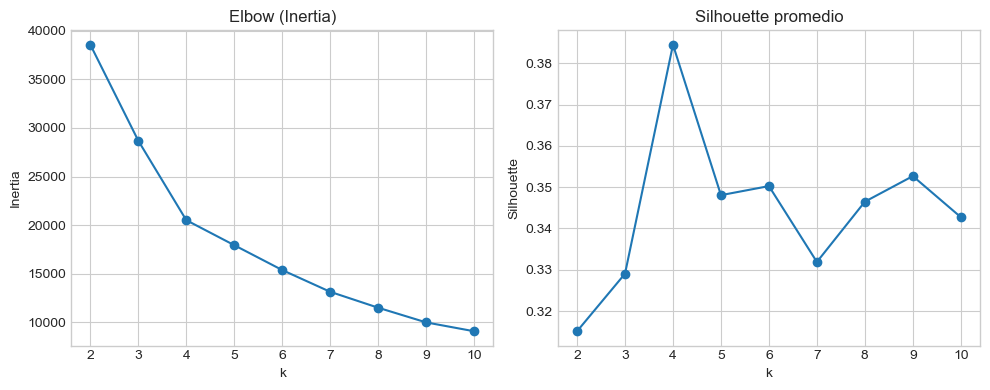

,k,inertia,silhouette,davies_bouldin
0,2,38556.719496,0.3151,1.1694
1,3,28677.724811,0.3290,1.0251
2,4,20507.893725,0.3845,0.8210
3,5,17934.880282,0.3481,0.9546
4,6,15376.477414,0.3503,0.8063
5,7,13137.952892,0.3319,0.8215
6,8,11502.027798,0.3465,0.7592
7,9,9991.257336,0.3527,0.7798
8,10,9080.342935,0.3427,0.7772


In [32]:
# ======================================
# K-means — Búsqueda de k
# ======================================
ks = range(2, 11)
inertias = []
silhouettes = []
db_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    silhouettes.append(sil)
    db_scores.append(db)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(ks), inertias, marker="o")
ax[0].set_title("Elbow (Inertia)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(list(ks), silhouettes, marker="o")
ax[1].set_title("Silhouette promedio")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

pd.DataFrame({
    "k": ks,
    "inertia": inertias,
    "silhouette": np.round(silhouettes, 4),
    "davies_bouldin": np.round(db_scores, 4)
})


In [33]:
# ======================================
# K-means — Candidatos (k=4..6)
# ======================================
candidatos = [4, 5, 6]
resultados = []

modelos = {}
labels_dict = {}

for k in candidatos:
    km = KMeans(n_clusters=k, n_init=30, random_state=SEED)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    modelos[k] = km
    labels_dict[k] = labels
    resultados.append({"k": k, "silhouette": sil, "davies_bouldin": db})

comparacion = pd.DataFrame(resultados).sort_values("silhouette", ascending=False)
comparacion


,k,silhouette,davies_bouldin
0,4,0.384414,0.821003
2,6,0.350264,0.806280
1,5,0.348068,0.954556


In [34]:
# ======================================
# K-means — Selección de k y etiquetado
# ======================================
# Regla simple: mayor silhouette (si empata, menor Davies-Bouldin)
best_k = comparacion.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]["k"]
best_k = int(best_k)
print(f"Mejor k (según métricas): {best_k}")

best_model = modelos[best_k]
rfm_km[f"KM_k{best_k}"] = labels_dict[best_k]

# Conteo por cluster
rfm_km[f"KM_k{best_k}"].value_counts().sort_index()


Mejor k (según métricas): 4


KM_k4
0     8205
1     7025
2    13499
3    14934
Name: count, dtype: int64

In [35]:
# ======================================
# K-means — Centroides y perfil de clusters
# ======================================
centroids_scaled = best_model.cluster_centers_
centroids_raw = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_raw, columns=["R_cont", "F_log", "M_log"])
centroids_df["F_cont_mediana_aprox"] = np.expm1(centroids_df["F_log"]).round(2)
centroids_df["M_cont_mediana_aprox"] = np.expm1(centroids_df["M_log"]).round(0)

centroids_df = centroids_df.drop(columns=["F_log", "M_log"])
centroids_df.index.name = "cluster"
centroids_df = centroids_df.reset_index()

print("Centroides aproximados (escala original):")
display(centroids_df)

# Perfil agregado por cluster (medianas reales)
perfil = (
    rfm_km
    .groupby(f"KM_k{best_k}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median")
    )
    .sort_values("M_med", ascending=False)
)
display(perfil)


Centroides aproximados (escala original):


,cluster,R_cont,F_cont_mediana_aprox,M_cont_mediana_aprox
0,0,322.577420,1.01,143220.0
1,1,172.287383,2.28,1454086.0
2,2,113.003402,1.09,414628.0
3,3,416.905087,1.08,505394.0


,clientes,R_med,F_med,M_med
KM_k4,,,,
1,7025,147.0,2.0,1302479.0
3,14934,386.0,1.0,491555.0
2,13499,116.0,1.0,411681.0
0,8205,332.0,1.0,154588.0


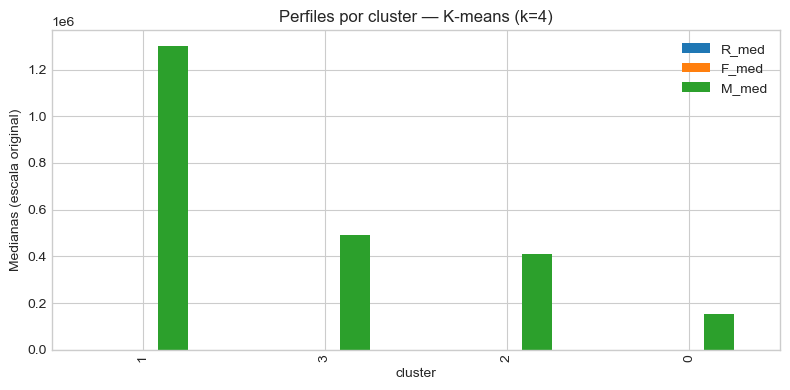

In [55]:
# ======================================
# K-means — Visualización simple de perfiles
# ======================================
cols = ["R_med", "F_med", "M_med"]
ax = perfil[cols].plot(kind="bar", figsize=(8,4))
ax.set_title(f"Perfiles por cluster — K-means (k={best_k})")
ax.set_xlabel("cluster")
ax.set_ylabel("Medianas (escala original)")
plt.tight_layout()
plt.show()


### 2. K-means - variables discretas

In [37]:
# ======================================
# K-means — (Variables discretas)
# ======================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42

# Dataset de entrada
X_disc_raw = rfm[["R_score", "F_score", "M_score"]].copy()

# Escalar (aunque ya estén en 1–5, el escalado asegura que todas las dimensiones pesen igual)
scaler_disc = StandardScaler()
X_disc = scaler_disc.fit_transform(X_disc_raw)

print("Shape de X_discretas:", X_disc.shape)
X_disc[:3]


Shape de X_discretas: (43663, 3)


array([[-1.41667873, -0.41656611,  0.70939649],
       [-0.0016528 , -0.41656611, -1.41252389],
       [ 0.70586016, -0.41656611, -1.41252389]])

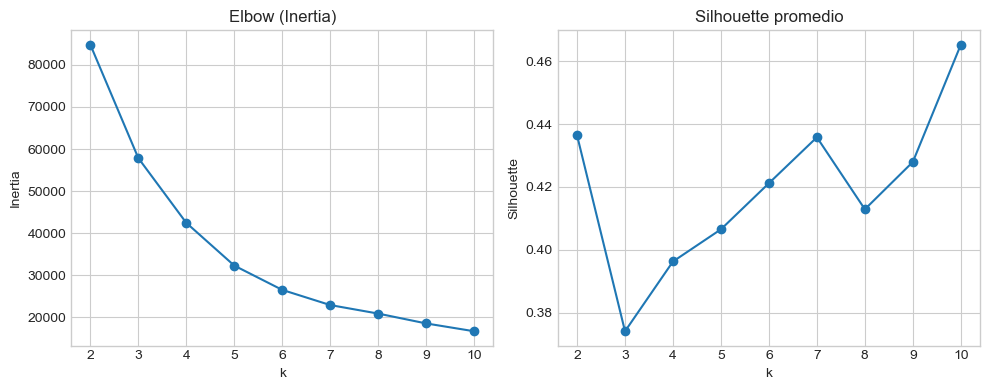

,k,inertia,silhouette,davies_bouldin
0,2,84786.911815,0.4364,0.9987
1,3,57849.762666,0.3742,1.0308
2,4,42457.543344,0.3963,0.8649
3,5,32300.719501,0.4066,0.8929
4,6,26524.645887,0.4212,0.8779
5,7,22922.731606,0.4358,0.8470
6,8,20894.224870,0.4129,0.9084
7,9,18553.730040,0.4280,0.8620
8,10,16694.835820,0.4652,0.8074


In [38]:
# ======================================
# K-means — Búsqueda de k (RFM discretas)
# ======================================

ks = range(2, 11)
inertias = []
silhouettes = []
db_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    labels = km.fit_predict(X_disc)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_disc, labels)
    db  = davies_bouldin_score(X_disc, labels)
    silhouettes.append(sil)
    db_scores.append(db)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(ks, inertias, marker="o")
ax[0].set_title("Elbow (Inertia)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(ks, silhouettes, marker="o")
ax[1].set_title("Silhouette promedio")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

pd.DataFrame({
    "k": ks,
    "inertia": inertias,
    "silhouette": np.round(silhouettes, 4),
    "davies_bouldin": np.round(db_scores, 4)
})


In [39]:
# ======================================
# K-means — Comparación candidatos (RFM discretas)
# ======================================
candidatos = [4, 5, 6,7]
resultados_disc = []
modelos_disc = {}
labels_disc = {}

for k in candidatos:
    km = KMeans(n_clusters=k, n_init=30, random_state=SEED)
    labels = km.fit_predict(X_disc)
    sil = silhouette_score(X_disc, labels)
    db  = davies_bouldin_score(X_disc, labels)
    modelos_disc[k] = km
    labels_disc[k] = labels
    resultados_disc.append({"k": k, "silhouette": sil, "davies_bouldin": db})

comparacion_disc = pd.DataFrame(resultados_disc).sort_values("silhouette", ascending=False)
comparacion_disc


,k,silhouette,davies_bouldin
3,7,0.435796,0.847021
2,6,0.421205,0.877874
1,5,0.406552,0.892946
0,4,0.396676,0.828018


In [40]:
# ======================================
# K-means — Selección de k óptimo (RFM discretas)
# ======================================
best_k_disc = comparacion_disc.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]["k"]
best_k_disc = int(best_k_disc)
print(f"Mejor k (según métricas discretas): {best_k_disc}")

best_model_disc = modelos_disc[best_k_disc]
rfm[f"KMdisc_k{best_k_disc}"] = labels_disc[best_k_disc]

rfm[f"KMdisc_k{best_k_disc}"].value_counts().sort_index()


Mejor k (según métricas discretas): 7


KMdisc_k7
0     8126
1    10013
2     1149
3     7529
4     3164
5     3717
6     9965
Name: count, dtype: int64

In [41]:
# ======================================
# K-means — Centroides y perfil (discretas)
# ======================================
centroids_disc = best_model_disc.cluster_centers_
centroids_disc_df = pd.DataFrame(centroids_disc, columns=["R_score", "F_score", "M_score"])
centroids_disc_df.index.name = "cluster"
centroids_disc_df = centroids_disc_df.reset_index()

print("Centroides medios (escala 1–5):")
display(centroids_disc_df)

# Perfil agregado por cluster en la escala original (R,F,M continuas)
perfil_disc = (
    rfm.groupby(f"KMdisc_k{best_k_disc}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median")
    )
    .sort_values("M_med", ascending=False)
)
display(perfil_disc)


Centroides medios (escala 1–5):


,cluster,R_score,F_score,M_score
0,0,-1.095486,-0.416566,0.520427
1,1,0.688761,-0.416566,0.492818
2,2,0.816082,4.346560,1.397005
3,3,-1.044175,-0.388638,-1.094992
4,4,-0.517529,1.277649,1.111336
5,5,1.088644,1.400659,1.137548
6,6,0.654314,-0.377399,-1.030514


,clientes,R_med,F_med,M_med
KMdisc_k7,,,,
2,1149,90.0,5.0,2491404.0
5,3717,84.0,2.0,1008320.0
4,3164,331.0,2.0,1003878.5
0,8126,429.0,1.0,564044.0
1,10013,140.0,1.0,550378.0
6,9965,148.0,1.0,260420.0
3,7529,405.0,1.0,222647.0


In [43]:
# ======================================
# Resumen de clusters K-Means con ticket promedio
# ======================================

# Calcular ticket promedio (valor pagado por compra)
rfm["avg_ticket"] = rfm["M_cont"] / rfm["F_cont"]

# Resumen por cluster — continuo (K-means con valores reales)
perfil_cont = (
    rfm_km
    .assign(avg_ticket=lambda df: df["M_cont"] / df["F_cont"])
    .groupby(f"KM_k{best_k}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median"),
        ticket_med=("avg_ticket", "median")
    )
    .sort_values("M_med", ascending=False)
)

print(f"=== Resumen K-means continuo (k={best_k}) ===")
display(perfil_cont)

# Resumen por cluster — discreto (K-means con R_score, F_score, M_score)
perfil_disc = (
    rfm
    .groupby(f"KMdisc_k{best_k_disc}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median"),
        ticket_med=("avg_ticket", "median")
    )
    .sort_values("M_med", ascending=False)
)

print(f"=== Resumen K-means discreto (k={best_k_disc}) ===")
display(perfil_disc)


=== Resumen K-means continuo (k=4) ===


,clientes,R_med,F_med,M_med,ticket_med
KM_k4,,,,,
1,7025,147.0,2.0,1302479.0,628109.5
3,14934,386.0,1.0,491555.0,466345.0
2,13499,116.0,1.0,411681.0,376012.5
0,8205,332.0,1.0,154588.0,151218.0


=== Resumen K-means discreto (k=7) ===


,clientes,R_med,F_med,M_med,ticket_med
KMdisc_k7,,,,,
2,1149,90.0,5.0,2491404.0,521692.00
5,3717,84.0,2.0,1008320.0,461943.00
4,3164,331.0,2.0,1003878.5,475489.75
0,8126,429.0,1.0,564044.0,564044.00
1,10013,140.0,1.0,550378.0,550378.00
6,9965,148.0,1.0,260420.0,252059.00
3,7529,405.0,1.0,222647.0,218403.00


### 3. Fuzzy C-Means (FCM) - variables continuas

In [58]:
# ======================================
# Fuzzy C-Means (FCM) — (Varaiables continuas)
# ======================================
#import sys
#!{sys.executable} -m pip install scikit-fuzzy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.preprocessing import RobustScaler

# Usaremos las mismas variables continuas del K-means
rfm_fcm = rfm.copy()

# Escalado robusto (igual que en K-means continuo)
features = ["R_cont", "F_cont", "M_cont"]
X_raw = rfm_fcm[features].copy()
scaler = RobustScaler()
X = scaler.fit_transform(X_raw).T  # FCM requiere shape (features, samples)

print("Shape de X para FCM:", X.shape)


Shape de X para FCM: (3, 43663)


k=4 - FPC=0.6334
k=5 - FPC=0.6022
k=6 - FPC=0.5467
k=7 - FPC=0.5305


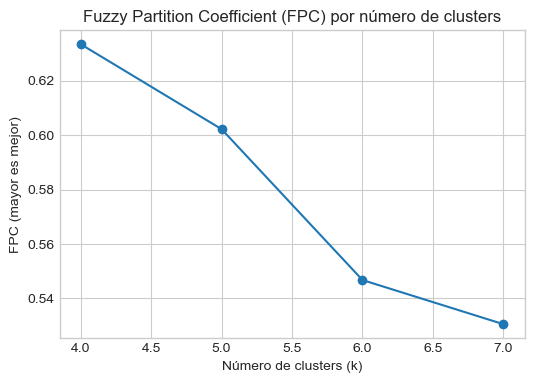

In [59]:
# ======================================
# Fuzzy C-Means — Búsqueda de k
# ======================================
# Definimos rango de clusters para probar (4 a 7, por consistencia)
ks = [4, 5, 6, 7]
fpcs = []  # Fuzzy Partition Coefficient

for k in ks:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=k, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpcs.append(fpc)
    print(f"k={k} - FPC={fpc:.4f}")

# Gráfico del Fuzzy Partition Coefficient (FPC)
plt.figure(figsize=(6,4))
plt.plot(ks, fpcs, marker='o')
plt.title("Fuzzy Partition Coefficient (FPC) por número de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("FPC (mayor es mejor)")
plt.show()


In [16]:
# ======================================
# Fuzzy C-Means — Entrenamiento final
# ======================================

best_k_fcm = 6  # ← ajusta según el FPC anterior
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X, c=best_k_fcm, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

print(f"Modelo FCM entrenado con k={best_k_fcm}, FPC={fpc:.4f}")

# Asignar el cluster de máxima pertenencia a cada cliente
cluster_labels = np.argmax(u, axis=0)
rfm_fcm[f"FCM_k{best_k_fcm}"] = cluster_labels


Modelo FCM entrenado con k=6, FPC=0.5467


In [17]:
# ======================================
# Fuzzy C-Means — Ejemplo de pertenencias difusas
# ======================================
membership_df = pd.DataFrame(u.T, columns=[f"p_cluster_{i}" for i in range(best_k_fcm)])
membership_df["Cliente"] = rfm_fcm[CLIENT_ID].values
display(membership_df.head())

# Revisar clientes frontera (pertenencias divididas)
membership_df["max_prob"] = membership_df[[f"p_cluster_{i}" for i in range(best_k_fcm)]].max(axis=1)
print("\nClientes con pertenencia difusa (max_prob < 0.7):",
      (membership_df["max_prob"] < 0.7).sum())


,p_cluster_0,p_cluster_1,p_cluster_2,p_cluster_3,p_cluster_4,p_cluster_5,Cliente
0,0.007214,0.053483,0.763333,0.064383,0.000875,0.110712,0
1,0.002055,0.010192,0.060715,0.084255,0.000321,0.842461,2323
2,0.003250,0.017187,0.059795,0.795489,0.000493,0.123786,10523
3,0.062923,0.591707,0.150281,0.097506,0.004578,0.093005,41603
4,0.015499,0.170586,0.341240,0.329373,0.001753,0.141549,88422



Clientes con pertenencia difusa (max_prob < 0.7): 23167


In [19]:
# ======================================
# Fuzzy C-Means — Perfil de clusters
# ======================================
perfil_fcm = (
    rfm_fcm
    .assign(avg_ticket=lambda df: df["M_cont"] / df["F_cont"])
    .groupby(f"FCM_k{best_k_fcm}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median"),
        ticket_med=("avg_ticket", "median")
    )
    .sort_values("M_med", ascending=False)
)

print(f"=== Resumen Fuzzy C-Means (k={best_k_fcm}) ===")
display(perfil_fcm)


=== Resumen Fuzzy C-Means (k=6) ===


,clientes,R_med,F_med,M_med,ticket_med
FCM_k6,,,,,
4,260,64.5,7.0,5448535.0,833829.208333
0,1450,126.0,3.0,2377510.5,699680.333333
1,5487,163.0,2.0,1171306.0,562442.000000
2,9494,377.0,1.0,615092.0,584882.000000
3,13874,107.0,1.0,382725.5,352899.000000
5,13098,342.0,1.0,260462.0,252017.000000


In [20]:
# ======================================
# Fuzzy C-Means — Centroides en escala original
# ======================================
centroids_scaled = cntr
centroids_raw = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_raw, columns=["R_cont", "F_cont", "M_cont"])
centroids_df.index.name = "cluster"
centroids_df = centroids_df.reset_index()

# Calcular ticket promedio aproximado para interpretar mejor
centroids_df["ticket_aprox"] = centroids_df["M_cont"] / centroids_df["F_cont"]
display(centroids_df.round(1))


,cluster,R_cont,F_cont,M_cont,ticket_aprox
0,0,164.2,3.5,2485772.6,707557.2
1,1,192.8,2.0,1214283.2,592386.4
2,2,381.5,1.1,630198.0,580294.0
3,3,105.4,1.0,390501.7,374292.3
4,4,107.5,7.4,6039214.9,821039.9
5,5,369.7,1.0,269573.6,262277.3


### 4. Fuzzy C-Means (FCM) - variables discretas

In [23]:
# ======================================
# Fuzzy C-Means — Variables Discretas
# ======================================
import skfuzzy as fuzz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

rfm_fcm_disc = rfm.copy()

# Matriz de entrada: escalamos 1–5 para igualar pesos
X_disc_raw = rfm_fcm_disc[["R_score", "F_score", "M_score"]].copy()
scaler_disc = StandardScaler()
X_disc_scaled = scaler_disc.fit_transform(X_disc_raw).T   # FCM espera (features, samples)

print("Shape de X_disc_scaled:", X_disc_scaled.shape)


Shape de X_disc_scaled: (3, 43663)


k=4 - FPC=0.5560
k=5 - FPC=0.5243
k=6 - FPC=0.4780
k=7 - FPC=0.4383


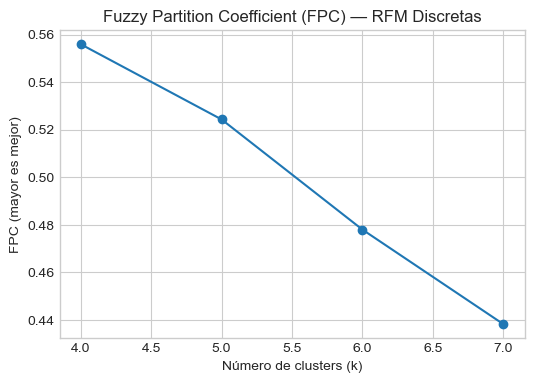

In [60]:
# ======================================
# Fuzzy C-Means — Búsqueda de k (discretas)
# ======================================
ks = [4, 5, 6, 7]
fpcs_disc = []

for k in ks:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_disc_scaled, c=k, m=2, error=0.005, maxiter=1000, seed=42
    )
    fpcs_disc.append(fpc)
    print(f"k={k} - FPC={fpc:.4f}")

plt.figure(figsize=(6,4))
plt.plot(ks, fpcs_disc, marker='o')
plt.title("Fuzzy Partition Coefficient (FPC) — RFM Discretas")
plt.xlabel("Número de clusters (k)")
plt.ylabel("FPC (mayor es mejor)")
plt.show()


In [25]:
# ======================================
# Fuzzy C-Means — Entrenamiento final (discretas)
# ======================================
best_k_fcm_disc = 7   # ← ajusta según tu FPC
cntr_disc, u_disc, u0_disc, d_disc, jm_disc, p_disc, fpc_disc = fuzz.cluster.cmeans(
    X_disc_scaled, c=best_k_fcm_disc, m=2, error=0.005, maxiter=1000, seed=42
)

print(f"Modelo FCM (discretas) entrenado con k={best_k_fcm_disc}, FPC={fpc_disc:.4f}")

# Etiqueta dominante por cliente
cluster_labels_disc = np.argmax(u_disc, axis=0)
rfm_fcm_disc[f"FCMdisc_k{best_k_fcm_disc}"] = cluster_labels_disc


Modelo FCM (discretas) entrenado con k=7, FPC=0.4383


In [26]:
# ======================================
# Fuzzy C-Means — Perfil agregado (discretas)
# ======================================
perfil_fcm_disc = (
    rfm_fcm_disc
    .assign(avg_ticket=lambda df: df["M_cont"] / df["F_cont"])
    .groupby(f"FCMdisc_k{best_k_fcm_disc}")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        R_med=("R_cont", "median"),
        F_med=("F_cont", "median"),
        M_med=("M_cont", "median"),
        ticket_med=("avg_ticket", "median")
    )
    .sort_values("M_med", ascending=False)
)

print(f"=== Resumen Fuzzy C-Means (discretas, k={best_k_fcm_disc}) ===")
display(perfil_fcm_disc)


=== Resumen Fuzzy C-Means (discretas, k=7) ===


,clientes,R_med,F_med,M_med,ticket_med
FCMdisc_k7,,,,,
4,2678,119.0,3.0,1761037.0,493794.041667
1,6219,93.0,1.0,743614.0,610811.000000
6,5460,289.0,1.0,642815.0,525168.000000
0,8716,436.0,1.0,575588.0,554588.000000
3,8160,84.0,1.0,340294.0,340294.000000
2,7530,405.0,1.0,222647.0,218403.000000
5,4900,264.0,1.0,189034.0,178550.000000


In [28]:
# ======================================
# Fuzzy C-Means — Centroides (escala discreta) [FIX]
# ======================================
# cntr_disc tiene shape (k, 3) en el espacio ESCALADO
centroids_disc_scaled = cntr_disc  # shape: (k, 3)

# Invertir el escalado a la escala 1..5 (sin transponer)
centroids_disc = scaler_disc.inverse_transform(centroids_disc_scaled)  # -> (k, 3)

centroids_df_disc = pd.DataFrame(
    centroids_disc, columns=["R_score", "F_score", "M_score"]
).round(2)
centroids_df_disc.index.name = "cluster"
display(centroids_df_disc)


,R_score,F_score,M_score
cluster,,,
0,1.32,1.06,3.95
1,4.42,1.18,4.08
2,1.38,1.02,1.62
3,4.49,1.03,2.01
4,4.20,3.44,4.92
5,2.97,1.02,1.40
6,2.98,1.17,4.00


# Resultados de los modelos de clustering

Para evaluar la segmentación de clientes basada en las variables RFM (Recency, Frequency, Monetary), se aplicaron cuatro enfoques de clustering no supervisado:

1. **K-Means con variables continuas**  
2. **K-Means con variables discretizadas (scores 1–5)**  
3. **Fuzzy C-Means (FCM) con variables continuas**  
4. **Fuzzy C-Means (FCM) con variables discretizadas**

A continuación se presentan los principales hallazgos y características observadas en cada modelo.

---

## 1. K-Means con variables continuas

El modelo continuo produjo **4 clusters** claramente diferenciados:

- Un segmento de alto valor, reciente y frecuente.
- Un segmento de valor medio.
- Un segmento de valor bajo pero reciente.
- Un segmento dormido de bajo valor.

Si bien el modelo mostró buena compacidad y separación, los clusters resultaron ser **macrosegmentos**, con poca granularidad para acciones de marketing diferenciadas. La interpretabilidad directa no es tan intuitiva debido a las escalas continuas.

**Conclusión:**  
Robusto y estable, pero poco granular.

---

## 2. K-Means con variables discretas (scores 1–5)

Este modelo generó **7 clusters**, con una separación más rica y accionable.  
La discretización mitigó el efecto de outliers y permitió que los centroides fueran fácilmente interpretables en escala 1–5.

Los segmentos obtenidos fueron:

- **Champions**
- **Leales recientes**
- **En riesgo (alto valor)**
- **Ocasionales antiguos**
- **Nuevos / ticket alto**
- **Nuevos / ticket bajo**
- **Dormidos bajo valor**

Esta estructura coincide con patrones típicos de comportamiento en retail y e-commerce, y facilita la comunicación de resultados a áreas de negocio como CRM, marketing o loyalty.

**Conclusión:**  
Mayor granularidad, interpretabilidad clara y separaciones más útiles para decisiones comerciales.

---

## 3. Fuzzy C-Means con variables continuas

El modelo difuso continuo detectó **6 clusters**, con valores estables y bien diferenciados.  
La principal ventaja fue la capacidad de identificar **clientes frontera**, es decir, aquellos que no pertenecen totalmente a un segmento sino que muestran transiciones entre perfiles.

Sin embargo, esa misma característica hizo que la interpretación fuera menos directa y dificultara el uso operacional inmediato (por ejemplo, etiquetar clientes para campañas).

**Conclusión:**  
Excelente para análisis fino, pero menos práctico para etiquetar segmentos de forma rígida.

---

## 4. Fuzzy C-Means con variables discretizadas

El modelo FCM discreto generó **7 clusters**, con una estructura parecida a la de K-Means discreto.  
Los resultados fueron coherentes, pero los grados de pertenencia difusos no aportaron una ventaja significativa adicional sobre la versión crisp de K-Means.

**Conclusión:**  
Útil como comparación, pero menos estable y menos interpretable que su contraparte no difusa.

---

Después de comparar los cuatro modelos con criterios técnicos (cohesión, separación, FPC), analíticos (granularidad, estabilidad) y de negocio (interpretabilidad, aplicabilidad operativa), se seleccionó el modelo:

## **K-Means con variables discretas (k = 7)**

Las razones principales son:

### 1. Interpretabilidad superior  
Los centroides en escala 1–5 permiten explicar fácilmente cada segmento y su perfil RFM.

### 2. Granularidad adecuada  
Los 7 clusters presentan diferencias claras en recency, frecuencia y valor monetario, permitiendo estrategias específicas por segmento.

### 3. Estabilidad y reproducibilidad  
El modelo es menos sensible a outliers que los enfoques continuos y más estable que FCM.

### 4. Aplicabilidad práctica  
Permite asignar rápidamente un cluster a cada cliente, y usarlo como **variable objetivo** en modelos supervisados (árboles, redes neuronales, rough sets) para predicción de nuevos clientes.

---

A continuación, se procede a exportar los resultados finales del modelo (datos enriquecidos y tabla por cliente), así como el pipeline entrenado para ser reutilizado en fases posteriores del proyecto.


In [46]:
# ================================
# 1) Mapeo final de clusters (k=7)
#    Tomado de tu resumen y tus ajustes:
# ================================
# KMdisc_k7  ->  Nombre final
cluster_name_map = {
    2: "Champions",
    5: "Leales recientes",
    4: "En riesgo (alto valor)",
    0: "Ocasionales antiguos",
    1: "Nuevos / ticket alto",
    6: "Nuevos / ticket bajo",
    3: "Dormidos bajo valor",
}

# Detectar automáticamente la columna de labels de K-means DISCRETO (por si cambia el nombre)
disc_label_cols = [c for c in rfm.columns if c.startswith("KMdisc_k")]
assert len(disc_label_cols) > 0, "No encuentro columnas de K-means discreto (KMdisc_k*)."
label_col_disc = sorted(disc_label_cols, key=lambda x: int(x.split('k')[-1]))[-1]  # toma la de mayor k
best_k_disc = int(label_col_disc.split('k')[-1])

print(f"Usando columna de cluster discreto: {label_col_disc} (k={best_k_disc})")

# Ticket promedio auxiliar
rfm["avg_ticket"] = rfm["M_cont"] / rfm["F_cont"]


Usando columna de cluster discreto: KMdisc_k7 (k=7)


In [47]:
import joblib
joblib.dump(cluster_name_map, f"kmeans_discreto_k{best_k_disc}_cluster_names.joblib")
print("Nombres de cluster actualizados guardados en disco.")


✅ Nombres de cluster actualizados guardados en disco.


In [48]:
# ================================
# 2) Tabla final por cliente
# ================================
# Adjuntar nombre definitivo desde el mapeo explícito (no reglas)
rfm["cluster_name"] = rfm[label_col_disc].map(cluster_name_map).fillna("NA")

cols_cliente = [
    CLIENT_ID,
    "R_cont","F_cont","M_cont",
    "R_score","F_score","M_score","RFM_code",
    "avg_ticket",
    label_col_disc,"cluster_name"
]
rfm_clientes = rfm[cols_cliente].copy()

print("Muestra tabla por cliente:")
display(rfm_clientes.head())


Muestra tabla por cliente:


,Client_Document,R_cont,F_cont,M_cont,R_score,F_score,M_score,RFM_code,avg_ticket,KMdisc_k7,cluster_name
0,0,470,1,768866,1,1,4,R1F1M4,768866.000000,0,Ocasionales antiguos
1,2323,317,1,176445,3,1,1,R3F1M1,176445.000000,6,Nuevos / ticket bajo
2,10523,116,1,234429,4,1,1,R4F1M1,234429.000000,6,Nuevos / ticket bajo
3,41603,343,3,1115876,2,3,5,R2F3M5,371958.666667,4,En riesgo (alto valor)
4,88422,143,1,810882,4,1,5,R4F1M5,810882.000000,1,Nuevos / ticket alto


In [51]:
# ======================================
# Exportación final — Solo en formato CSV
# ======================================

# Aseguramos que los identificadores y nombres sean strings
orders_enriched[CLIENT_ID] = orders_enriched[CLIENT_ID].astype(str)
rfm_clientes[CLIENT_ID] = rfm_clientes[CLIENT_ID].astype(str)
orders_enriched["cluster_name"] = orders_enriched["cluster_name"].astype(str)
rfm_clientes["cluster_name"] = rfm_clientes["cluster_name"].astype(str)

# Exportación
orders_enriched.to_csv("orders_enriched_with_RFM_KMdisc.csv", index=False, encoding="utf-8-sig")
rfm_clientes.to_csv("clientes_RFM_KMdisc.csv", index=False, encoding="utf-8-sig")

print("Archivos CSV exportados correctamente:")
print(" - orders_enriched_with_RFM_KMdisc.csv")
print(" - clientes_RFM_KMdisc.csv")


✅ Archivos CSV exportados correctamente:
 - orders_enriched_with_RFM_KMdisc.csv
 - clientes_RFM_KMdisc.csv


In [50]:
# ================================
# 4) Guardar modelo (Pipeline) + nombres
# ================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import numpy as np

# Matriz de entrenamiento del modelo discreto
X_disc_train = rfm[["R_score","F_score","M_score"]].values

# Reentrenar pipeline con el mismo k (discreto)
pipe_km_disc = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("kmeans", KMeans(n_clusters=best_k_disc, n_init=30, random_state=42))
])

pipe_km_disc.fit(X_disc_train)

# Guardar pipeline y el mapeo de nombres
joblib.dump(pipe_km_disc, f"kmeans_discreto_k{best_k_disc}_pipeline.joblib")
joblib.dump(cluster_name_map, f"kmeans_discreto_k{best_k_disc}_cluster_names.joblib")

print(f"Modelo guardado: kmeans_discreto_k{best_k_disc}_pipeline.joblib")
print(f"Nombres de cluster guardados: kmeans_discreto_k{best_k_disc}_cluster_names.joblib")


✅ Modelo guardado: kmeans_discreto_k7_pipeline.joblib
✅ Nombres de cluster guardados: kmeans_discreto_k7_cluster_names.joblib
